In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numba import njit
from tqdm.notebook import tqdm

# Deterministic CUR decomposition algorithm

This is the ordinary deterministic CUR implementation (Bien, J., Xu, Y., and Mahoney, M. W. CUR from a Sparse Optimization Viewpoint. In NeurIPS, pp. 217–225, 2010.)

In [2]:
###Compute W according to Algorithm 1
#Auxuluary function for computing optimality score
def compute_XW(X, W, i):
    n, p = X.shape
    XW = np.zeros((n, p))
    for j in range(p):
        if i != j:
            XW += np.outer(X[:,[j]], W[[j], :])
    return XW

#COORDINATE DESCENT for CUR deterministic problem
def coordinate_descent(X, A, W, lmb, eps):
    """
    X - array of the matrix to decompose;
    A - set of column indices to iterate
    W - matrix of parameters
    lmb - regularization coefficient of the optimization problem
    eps - convergence tolerance 
    """
    W = W.copy()
    X = X.copy()
    X = X / np.linalg.norm(X, axis=0)
    n, p = X.shape
    W_new = W.copy()
    if len(A) == 0:
        print('Empty set of indices')
        return W
    
    while True:
        for i in A:
            XW = compute_XW(X=X, W=W, i=i)
            z_i = X[:,[i]].T @ (X - XW) #eq(4)
            assert z_i.shape == (1, p), "dimensionality error"
            norm_z = np.linalg.norm(z_i)
            
            step = (1 - lmb/norm_z)
            step = step if step > 0.0 else 0.0 #eq(3)

            W_new[i,:] = step * z_i #eq(2)
            
        if np.linalg.norm(W_new - W, ord='fro') < eps:
            W = W_new
            break
        else:
            W = W_new
    return W

#return CUR matrices computed by algorithm 1
def CUR(X, lmb, eps):
    n, p = X.shape
    #col search
    W = np.zeros((p, p))
    A = np.arange(p)
    W_col = coordinate_descent(X=X, A=A, W=W, lmb=lmb, eps=eps)
    
    #row search
    W = np.zeros((n, n))
    A = np.arange(n)
    X = X.T.copy()
    W_row = coordinate_descent(X=X, A=A, W=W, lmb=lmb, eps=eps)

    #extract indices
    X = X.T.copy()
    Icol = np.argwhere(np.any(W_col, axis=1)).ravel()
    Irow = np.argwhere(np.any(W_row, axis=1)).ravel()
    
    #extract CUR
    C = X[:, Icol]
    R = X[Irow, :]
    II, JJ = np.meshgrid(Irow, Icol)
    U = X[II, JJ].T

    return C, U, R


# Stochastic CUR decomposition algorithm

Now we reconstruct the stochastic CUR algorithm according to the paper Mahoney, M. W., Maggioni, M., and Drineas, P. Tensor-CUR Decompositions for Tensor-based Data. In KDD, pp. 327–336, 2006.

Stochastic CUR
1. Compute v1, . . . , vk (the top k right singular vectors of A)
and the normalized statistical leverage scores
$$
A^{j}=\sum_{\xi=1}^{r}\left(\sigma_{\xi} u^{\xi}\right) v_{j}^{\xi}\rightarrow \text{ replace r with k<r}
$$
Normalized statistical leverage:
$$
\pi_{j}=\frac{1}{k} \sum_{\xi=1}^{k}\left(v_{j}^{\xi}\right)^{2}
$$
2. Keep the jth column of A with probability $p_j$ = min{1, $cπ_j$},
for all j ∈ {1, . . . , n}, where $c = O(k \log k/\epsilon^2)$.
3. Return the matrix C consisting of the selected columns
of A.

There is also an option to perform truncated SVD inside of the algorithm, but for comparison with deterministic CUR it is enough to use standart tool of np.linalg.

In [3]:
import sklearn
def ColumnSelect(A, k, eps, scikt = False):
  n =  A.shape[1]
  # print(n)
  if scikt:
    u, s, v_k = sklearn.utils.extmath.randomized_svd(A,k)
  else:
    u, s, vh = np.linalg.svd(A,full_matrices=False)
    v_k = vh[0:k,:]
  # print(v_k.shape)
  py = np.array([1 / k * np.sum(v_k[:,i]**2) for i in range(n)])
  # print('py: ', py[0:10])
  c = k * np.log(k)/ eps**2
  # print(c)
  c_index = [np.random.choice(2, p=[1-min(1,c*py[i]), min(1,c*py[i])]) for i in range(n)]
  # print(c_index)
  c_index = np.array(np.nonzero(c_index))
  # print(c_index)
  C = A[:, c_index.flatten()]
  return C

def CUR_stokh(A,k,eps,scikit=False):
  C = ColumnSelect(A, k, eps, False)
  R = ColumnSelect(A.T, k, eps, False)
  # print(R.shape)
  R = R.T;
  U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)

  return C, U, R


Here we define a function that easily tests the approximation quality in a defined range of parameters k and $\epsilon$. 

In [4]:
def CUR_stoch_test1(X, k, epsl, numiter, par_min=True, par_mean=False):
  CUR_stoch_err_min = np.zeros_like(epsl)
  CUR_stoch_err_mean = np.zeros_like(epsl)
  sz0_mean = np.zeros_like(epsl)
  sz1_mean = np.zeros_like(epsl)
  sz0_min = np.zeros_like(epsl)
  sz1_min = np.zeros_like(epsl)
  sz0_sto = np.zeros_like(epsl)
  sz1_sto = np.zeros_like(epsl)
  err_inner = np.zeros(numiter)
  sz0_inner = np.zeros(numiter)
  sz1_inner = np.zeros(numiter)

  for i in range(len(epsl)):
      for j in range(numiter):
        C, U, R = CUR_stokh(X, k, epsl[i], False)
        X_CUR = C@ U @R
        err_inner[j] = np.linalg.norm(X-X_CUR,'fro')/np.linalg.norm(X,'fro')
        sz0_inner[j] = U.shape[0]
        sz1_inner[j] = U.shape[1]

      min_ind = np.argmin(err_inner)
      CUR_stoch_err_mean[i] = np.mean(err_inner)
      CUR_stoch_err_min[i] = err_inner[min_ind]
      sz0_mean[i] = np.mean(sz0_inner)
      sz1_mean[i] = np.mean(sz1_inner)
      sz0_min[i] = sz0_inner[min_ind]
      sz1_min[i] = sz1_inner[min_ind]
  if par_min and not par_mean:
    return CUR_stoch_err_min, sz0_min, sz1_min
  if not par_min and par_mean:
    return CUR_stoch_err_mean, sz0_mean, sz1_mean
  if par_min and par_mean:
    return CUR_stoch_err_min, sz0_min, sz1_min, CUR_stoch_err_mean, sz0_mean, sz1_mean




We also define a function for easy visualization of the data obtained with CUR_stoch_test1.

In [5]:
def plot_CUR_stoch(CUR_stoch_err, epsl, sz0, sz1,k, numiter,const_lev=0): 
  fig, ax1 = plt.subplots(figsize=(12,5.5))

  color = 'tab:red'
  ax1.set_xlabel("$\epsilon$", fontsize=24)
  ax1.set_ylabel("Number of dimensions ", fontsize=24, color=color)
  ax1.semilogx(epsl, sz0, label = "U.shape[0]", color = 'tab:red')
  ax1.semilogx(epsl, sz1, label = "U.shape[1]", color = 'tab:orange')

  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(fontsize=13)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24, color=color)  # we already handled the x-label with ax1
  ax2.loglog(epsl, CUR_stoch_err, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  # plt.title("Stochastic CUR with k = {}, Error over {} iterations\n Global minimum is for U.shape = ({},{})".format(k, numiter,int(sz0_min[np.argmin(CUR_stoch_err)]),int(sz1_min[np.argmin(CUR_stoch_err)])), fontsize=24)
  plt.title("Stochastic CUR with k = {}, Error over {} iterations".format(k, numiter), fontsize=24)
  plt.show()
  return 0

# Tests with Radial Basis Function matrix

We create a radial basis function matrix.

In [ ]:
#RBF matrix for R+
N = 50
xi = np.array([i/(N-1) for i in range(N)])
xj = np.array([i/(N-1) for i in range(N)])
xx, yy = np.meshgrid(xi, xj)
A_rbf = np.exp(-np.sqrt(xx**2 + yy**2))

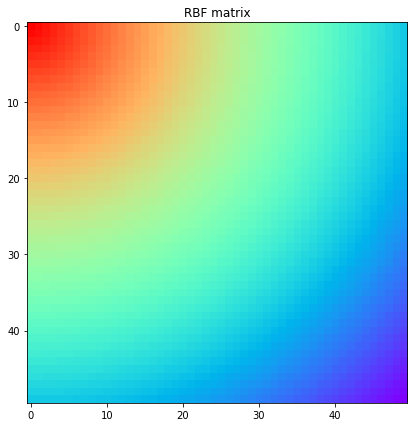

In [ ]:
plt.figure(figsize=(15,7))
plt.imshow(np.log(A_rbf), cmap='rainbow')
plt.title('RBF matrix')
plt.show()

SVD decomposition of RBF matrix shows that it can de successfully approximated with a low-rank matrix.

(array([1.e-19, 1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-04, 1.e-01, 1.e+02,
        1.e+05, 1.e+08]), <a list of 10 Text major ticklabel objects>)

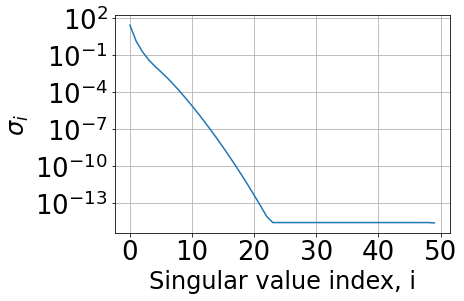

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# plt.rc("text", usetex=True)

u, s, v = np.linalg.svd(A_rbf)
plt.semilogy(s)
plt.ylabel("$\sigma_i $", fontsize=24)
plt.xlabel("Singular value index, i", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

$\lambda$ is the parameter to control the number of rows and columns used in the approximation.
$$
\min _{\mathbf{W} \in \mathbb{R}^{p \times_{p}}} \frac{1}{2}\|\mathbf{X}-\mathbf{X} \mathbf{W}\|_{F}^{2}+\lambda \sum_{i=1}^{p}\left\|\mathbf{W}_{(i)}\right\|_{2}
$$
The regularization constant $\lambda$ controls the degree of sparsity of the parameter matrix W. If $W_{(i)}$ is a zero vector, the corresponding
column of the data matrix $X^{(i)}$ can be considered as an
unimportant column for the problem.

In [ ]:
X = A_rbf
eps = 1e-3
lmb_range = np.linspace(15,0,151) 
sh0 = np.zeros_like(lmb_range)
sh1 = np.zeros_like(lmb_range)
Fnorm = np.zeros_like(lmb_range)
for i in range(len(lmb_range)):
  C, U, R = CUR(X=X, lmb=lmb_range[i], eps=eps)
  sh0[i] = U.shape[0]
  sh1[i] = U.shape[1]
  X_ = C@np.linalg.pinv(U)@R
  Fnorm[i] = np.linalg.norm(X - X_, ord='fro')

We plot the dependence of approximation quality (number of columns and rows and realtive error in Frobenius norm) as a function of parameter $\lambda$.

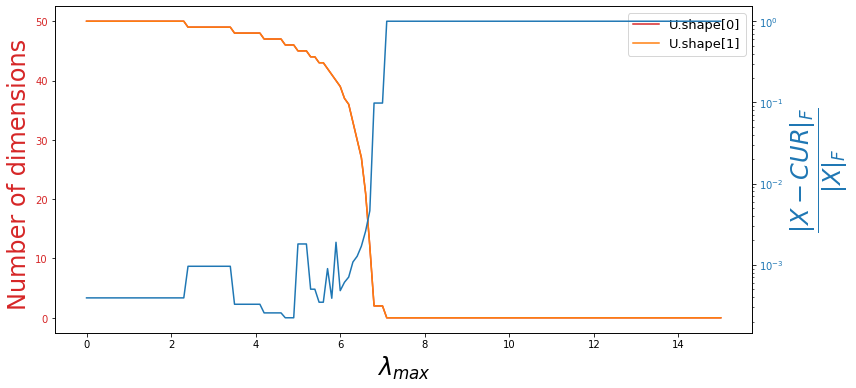

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5.5))

color = 'tab:red'
ax1.set_xlabel("$\lambda_{max}$", fontsize=24)
ax1.set_ylabel("Number of dimensions ", fontsize=24, color=color)
ax1.plot(lmb_range, sh0, label = "U.shape[0]", color = 'tab:red')
ax1.plot(lmb_range, sh1, label = "U.shape[1]", color = 'tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(fontsize=13)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24, color=color)  # we already handled the x-label with ax1
ax2.semilogy(lmb_range, Fnorm / np.linalg.norm(X,ord='fro'), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Here we compare deterministic CUR algorithm approximation with SVD low-rank approximation.

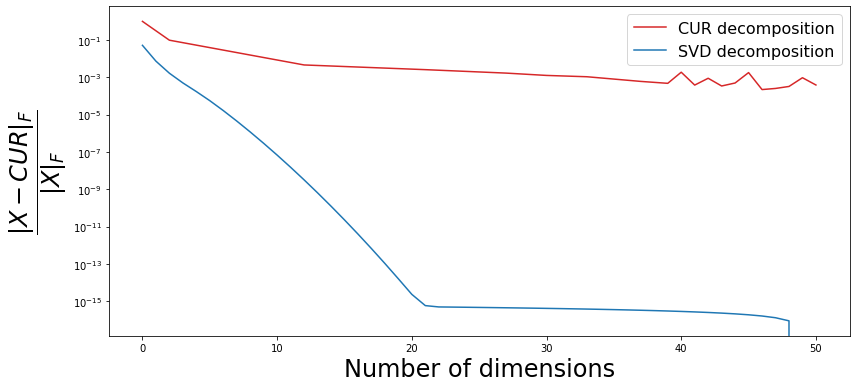

In [ ]:
u, s, v = np.linalg.svd(X)
svd_err = np.array([np.sqrt(np.sum(s[i+1:]**2)) for i in range(len(s))])

fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sh0, Fnorm / np.linalg.norm(X,ord='fro'), label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Here we perform the same analysis for RBF matrix, but use the stochastic CUR algorithm instead of deterministic one. We choose the parameter k equal to 10 and change $\epsilon$ in a wide range. Also for each pair of parameters we calculate 10 iterations and choose one corresponding to the best relative error. Note that the minimal relative error over the whole $\epsilon$ range is approximately equal to the rank k=10 SVD approximation error. 

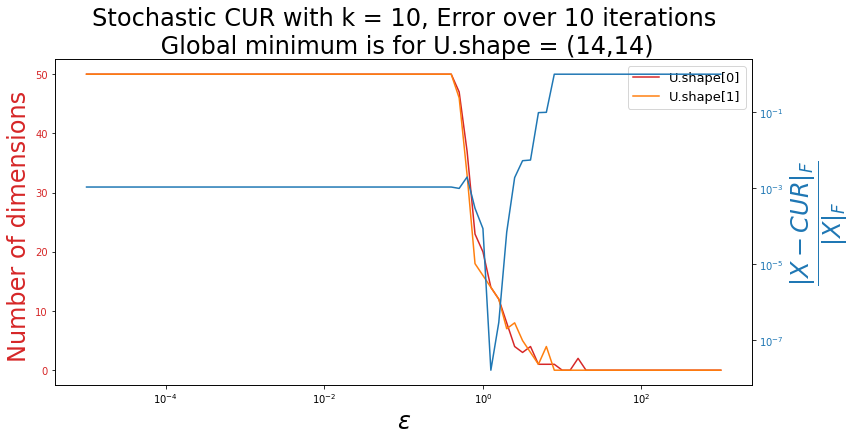

0

In [ ]:
k=10
numiter=10
epsl = 10**np.linspace(-5,3,81)
CUR_stoch_err_min, sz0_min, sz1_min = CUR_stoch_test1(A_rbf,k,epsl,numiter)
plot_CUR_stoch(CUR_stoch_err_min, epsl, sz0_min, sz1_min,k, numiter) 

We compare the quality of approximation with SVD. Note that when dimension is equal to 50, i.e. the full matrix is taken into consideration and no low-rank approximation is performed, realtive error is the same as for deterministic CUR. It is not equal to machine precision because RBF matrix is quite close to singular and pseudoinverse function works not that good. On the contrary, when one chooses to work with $\approx$ 15 columns and rows, relative error is sufficiently small. Comparison with deterministic CUR shows that for the RBF matrix combination of SVD-based weights and randomness of choice leads to better column selection. 

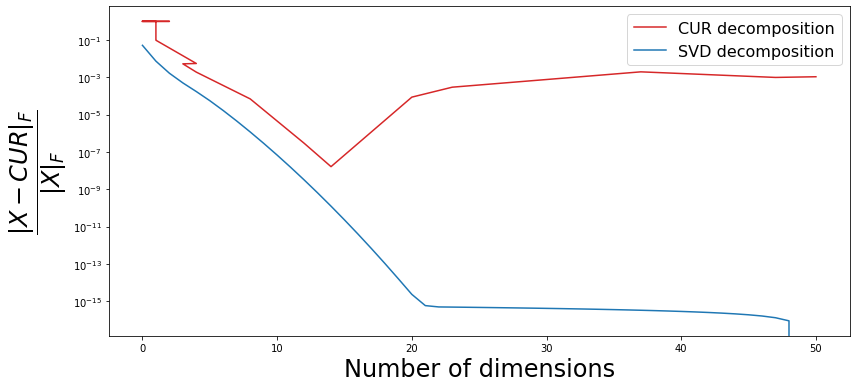

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sz0_min, CUR_stoch_err_min, label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Tests with a low-rank matrix 

Let's proceed with another example - a matrix that is constructed as a sum of 10 dyads or 10 outer products of randomly generated vectors. We expect that CUR decomposition should work perfectly in this case. First we imply the stochastic algorithm.

In [6]:
ss1=100;
ss2=90;
N = 1
mults = np.linspace(1,10,N)
for i in range(N):
  s1 = int(ss1*mults[i])
  s2 = int(ss2*mults[i])
  Matrix_bra_ket = np.zeros((s1,s2))
  for j in range(10):
    a = j*np.random.rand(s1)
    b = np.random.rand(s2)
    Matrix_bra_ket = Matrix_bra_ket+(a[:,None] * b)

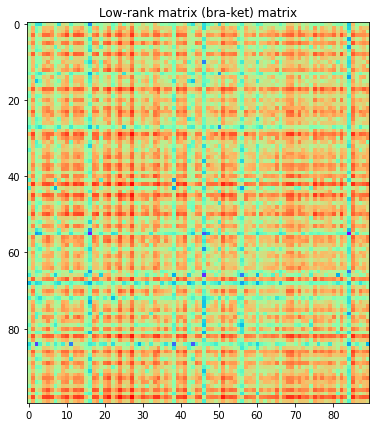

In [8]:
plt.figure(figsize=(15,7))
plt.imshow(np.log(Matrix_bra_ket), cmap='rainbow')
plt.title('Low-rank matrix (bra-ket) matrix')
plt.show()

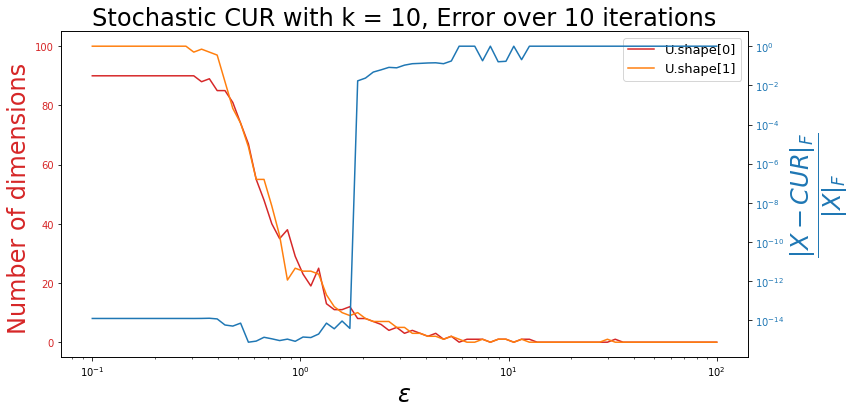

0

In [ ]:
X = Matrix_bra_ket# / np.linalg.norm(Matrix_bra_ket, axis=0)
k=10
numiter=10
epsl = 10**np.linspace(-1,2,81)
CUR_stoch_err_min, sz0_min, sz1_min = CUR_stoch_test1(Matrix_bra_ket,k,epsl,numiter)
plot_CUR_stoch(CUR_stoch_err_min, epsl, sz0_min, sz1_min,k, numiter) 

One can see that as soon as the number of chosen columns and rows reaches 10 realtive error becomes negligebly small. The comparison with SVD follows and one can see that CUR can provide the same performance and simultaneously decompose the initial matrix in the meaningfull basis.

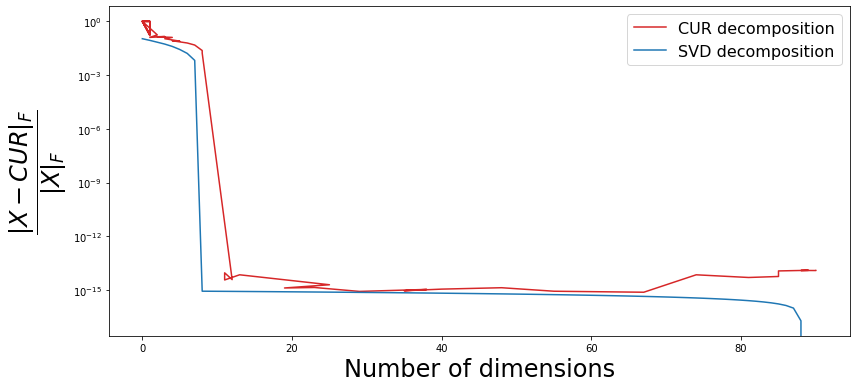

In [ ]:
u, s, v = np.linalg.svd(Matrix_bra_ket)
svd_err = np.array([np.sqrt(np.sum(s[i+1:]**2)) for i in range(len(s))])

fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sz0_min, CUR_stoch_err_min, label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

We investigate the same rank=10 matrix with the deterministic approach.

In [ ]:
k=10
numiter=10
epsl = 10**np.linspace(-2,2,81)
X = Matrix_bra_ket
eps = 1e-3
lmb_range = np.concatenate((np.linspace(0.9,8,81),np.linspace(8,11,81)),axis =0) 
sh0 = np.zeros_like(lmb_range)
sh1 = np.zeros_like(lmb_range)
Fnorm = np.zeros_like(lmb_range)
for i in range(len(lmb_range)):
  print(i)
  C, U, R = CUR(X=X, lmb=lmb_range[i], eps=eps)
  sh0[i] = U.shape[0]
  sh1[i] = U.shape[1]
  X_ = C@np.linalg.pinv(U)@R
  Fnorm[i] = np.linalg.norm(X - X_, ord='fro')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


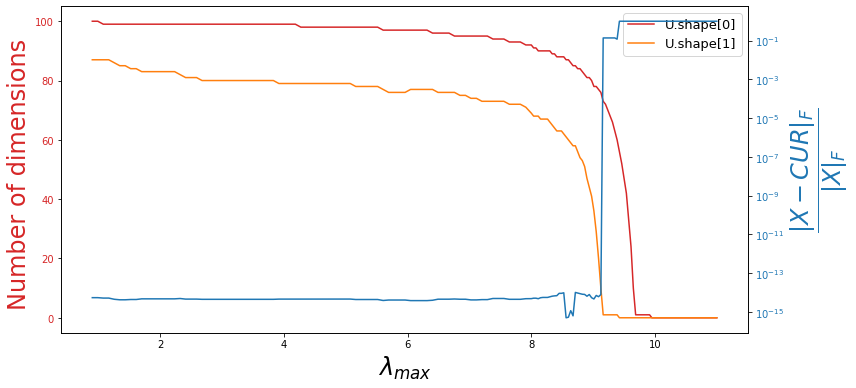

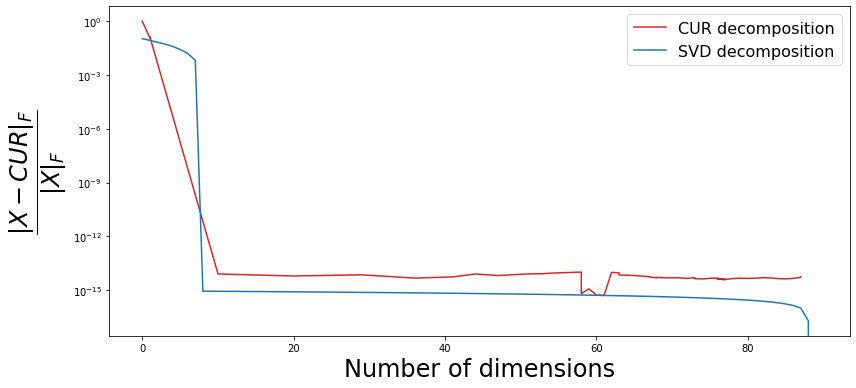

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5.5))

color = 'tab:red'
ax1.set_xlabel("$\lambda_{max}$", fontsize=24)
ax1.set_ylabel("Number of dimensions ", fontsize=24, color=color)
ax1.plot(lmb_range, sh0, label = "U.shape[0]", color = 'tab:red')
ax1.plot(lmb_range, sh1, label = "U.shape[1]", color = 'tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(fontsize=13)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24, color=color)  # we already handled the x-label with ax1
ax2.semilogy(lmb_range, Fnorm / np.linalg.norm(X,ord='fro'), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

u, s, v = np.linalg.svd(X)
svd_err = np.array([np.sqrt(np.sum(s[i+1:]**2)) for i in range(len(s))])

fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sh1, Fnorm / np.linalg.norm(X,ord='fro'), label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Results are also in a fine agreement with expectations. As soon as number of columns reaches 10 we are able to retrive the full matrix with perfect precision. Note that we have performed only columns selection for time reduction. Now we perform a test with a random matrix.

# Tests with a random matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


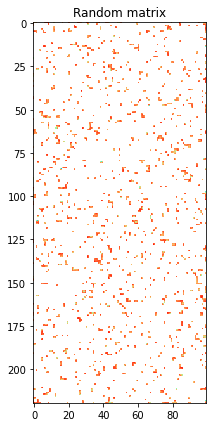

In [ ]:
X = np.random.randn(n,p)
plt.figure(figsize=(15,7))
plt.imshow(np.log(X), cmap='rainbow')
plt.title('Random matrix')
plt.show()

Stochastic CUR for random (220,100) matrix.

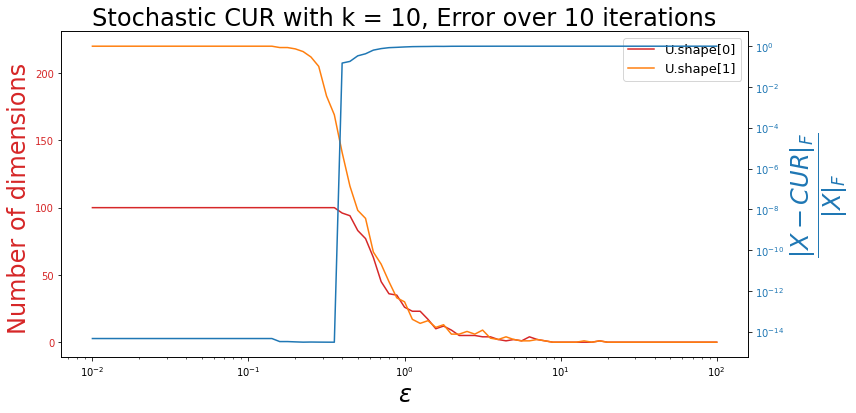

0

In [ ]:
k=10
numiter=10
epsl = 10**np.linspace(-2,2,81)
np.random.seed(10)
n, p = (220, 100)
X = np.random.randn(n,p)
CUR_stoch_err_min, sz0_min, sz1_min = CUR_stoch_test1(X,k,epsl,numiter)
plot_CUR_stoch(CUR_stoch_err_min, epsl, sz0_min, sz1_min,k, numiter) 

The approximation immediately converges as soon as we include all 100 columns in the approximation. This does not surpise us since the random matrix is always full rank. Later we can see the same result of the deterministic approach.

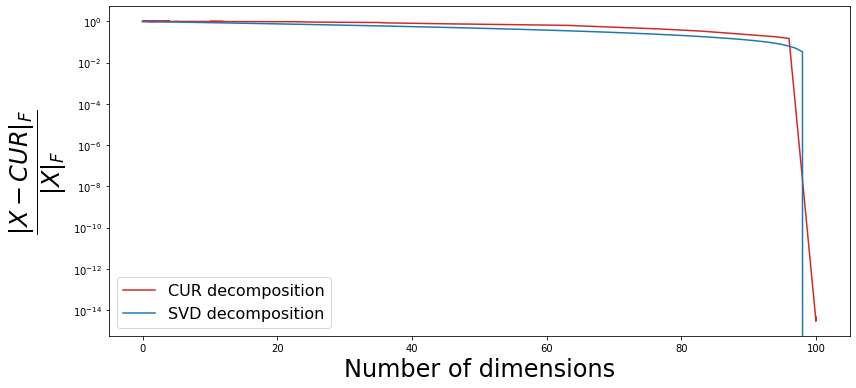

In [ ]:
u, s, v = np.linalg.svd(X)
svd_err = np.array([np.sqrt(np.sum(s[i+1:]**2)) for i in range(len(s))])

fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sz0_min, CUR_stoch_err_min, label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
k=10
numiter=10
epsl = 10**np.linspace(-2,2,81)
np.random.seed(10)
n, p = (220, 100)
X = np.random.randn(n,p)
eps = 1e-3
lmb_range = np.linspace(0.9,1.3,31) 
sh0 = np.zeros_like(lmb_range)
sh1 = np.zeros_like(lmb_range)
Fnorm = np.zeros_like(lmb_range)
for i in range(len(lmb_range)):
  print(i)
  C, U, R = CUR(X=X, lmb=lmb_range[i], eps=eps)
  sh0[i] = U.shape[0]
  sh1[i] = U.shape[1]
  X_ = C@np.linalg.pinv(U)@R
  Fnorm[i] = np.linalg.norm(X - X_, ord='fro')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


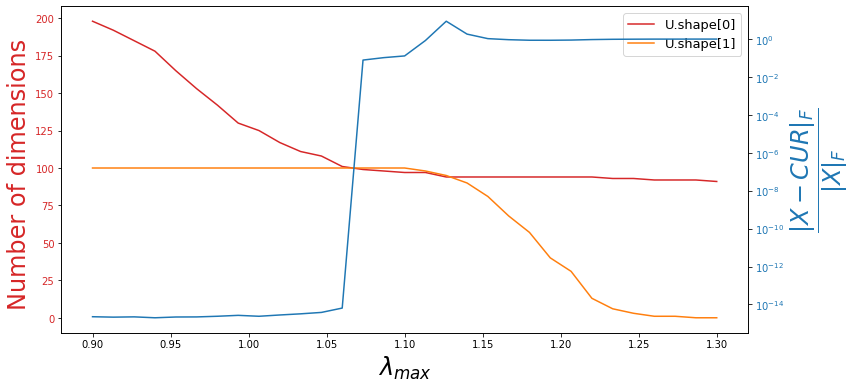

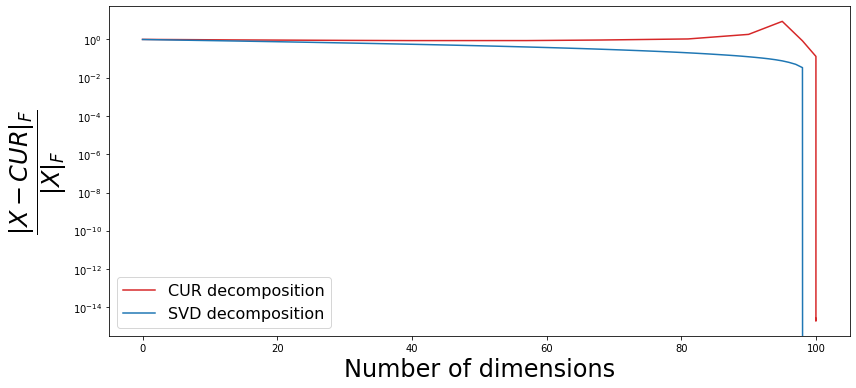

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,5.5))

color = 'tab:red'
ax1.set_xlabel("$\lambda_{max}$", fontsize=24)
ax1.set_ylabel("Number of dimensions ", fontsize=24, color=color)
ax1.plot(lmb_range, sh0, label = "U.shape[0]", color = 'tab:red')
ax1.plot(lmb_range, sh1, label = "U.shape[1]", color = 'tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(fontsize=13)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24, color=color)  # we already handled the x-label with ax1
ax2.semilogy(lmb_range, Fnorm / np.linalg.norm(X,ord='fro'), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

u, s, v = np.linalg.svd(X)
svd_err = np.array([np.sqrt(np.sum(s[i+1:]**2)) for i in range(len(s))])

fig, ax1 = plt.subplots(figsize=(12,5.5))

ax1.set_xlabel("Number of dimensions", fontsize=24)
ax1.set_ylabel("$\dfrac{\|X-CUR\|_F}{\|X\|_F} $", fontsize=24)
ax1.semilogy(sh1, Fnorm / np.linalg.norm(X,ord='fro'), label = "CUR decomposition", color = 'tab:red')
ax1.semilogy(svd_err / np.linalg.norm(X,ord='fro'), label = "SVD decomposition", color='tab:blue')
plt.legend(fontsize=16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Fast Deterministic CUR decomposition with Accuracy Assurance

In [ ]:
#Compute W according to Algorithm 2
import time
def FastCUR(X, 
            lmb_max=10, gamma=4, Q=10, eps=1e-3, 
            fixed_lmb=False, params=True):
    
    X = X.copy()
    X = X / np.linalg.norm(X, axis=0)
    n, p = X.shape
    if fixed_lmb == True:
        Q_lmb = [lmb_max] * Q
    else:
        Q_lmb = np.array([10**(-gamma * q / (Q - 1)) \
                          for q in range(Q)]) * lmb_max
    
    #line 1-3
    A = np.arange(p)
    G = (X.T)@X
    G_norms = np.array([np.linalg.norm(G[i,:]) for i in range(p)])
    W = np.zeros((p, p))
    W_tilde = np.zeros((p, p))
    # W_new is used for inner cycle termination
    W_new = np.ones((p, p)) * np.inf
    
    K_tilde = G_norms.copy()
    K_u = K_tilde.copy()
    K_l = np.zeros(p)
    time1 = np.zeros(Q)
    time2 = np.zeros(Q)
    
    delta = 0.0 #zero, since W = W_tilde = 0
    ##flag = 0
    
    M_global = []
    nonz_rows=np.zeros(Q)
    for it, lmb in enumerate(Q_lmb):
        tik = time.perf_counter()
        # print('iter:', it)
        M = []
        dW = W - W_tilde
        dW_norms = np.array([np.linalg.norm(dW[i,:]) for i in range(p)])
        dW_fro = np.linalg.norm(dW, ord='fro')

        for i in range(p):
            if it == 0:
                K_l = K_tilde
            else:
                K_l[i] = K_u[i] - 2 * (dW_norms[i] + delta * G_norms[i]) #eq(10)
            
            if K_l[i] > lmb:
                M.append(i)
        # print('\|W\|_F: ',np.linalg.norm(W, ord='fro'))
        W = coordinate_descent(X=X, A=M, W=W, lmb=lmb, eps=eps)
        # print('\|W\|_F after coordinate descent: ', np.linalg.norm(W, ord='fro'))
        tikin = time.perf_counter()
        while True:
            if np.linalg.norm(W_new - W, ord='fro') < eps:
                flag = 1
                break
            else:
                W_new = W

            W_tilde = W.copy() #line 15
            #cycle 16-17 - update K_tilde
            for i in A:
                z_i = X[:,[i]].T @ (X - compute_XW(X, W_tilde, i))
                K_tilde[i] = np.linalg.norm(z_i)
                
            for i in A:
                dW_i = dW[i,:] #W[i,:] - W_tilde[i,:]
                K_u[i] = K_tilde[i] + np.linalg.norm(dW_i) + delta * G_norms[i]
                
                if K_u[i] <= lmb:
                    W_prime = 0.0
                else:
                    z_i = X[:,[i]].T @ (X - compute_XW(X, W, i))
                    norm_z = np.linalg.norm(z_i)
                    step = (1 - lmb/norm_z) 
                    step = step if step > 0.0 else 0.0 #eq(3)
                    W_prime = step * z_i #eq2

                delta = np.sqrt(np.abs(dW_fro**2 - \
                                np.linalg.norm(dW_i)**2 + \
                                np.linalg.norm(W_prime - W_tilde[i,:])**2))
                
                W[i,:] = W_prime
        
        tocin = time.perf_counter()
        time2[it] = tocin - tikin
        # print('\|W\|_F inner circle',np.linalg.norm(W, ord='fro'))
        # print('Number of nonzero rows:', np.sum(np.all(W, axis=1)))
        M_global.append(M)
        toc = time.perf_counter()
        time1[it] = toc - tik
        nonz_rows[it]=np.sum(np.all(W, axis=1))
        print('Number of nonzero rows:', np.sum(np.all(W, axis=1)))
        #Global stop the algorithm
        if np.all(W)==True:
            print('Converges in {0} iteration'.format(it+1))
            break
    if params:
        return W, time1, time2, nonz_rows, M_global, Q_lmb[:it+1]
    else:
        return W, time1, time2, nonz_rows


Here we compare speed of the two deterministic approaches applied to a random matrix. We are not interested in approximation quality here, and only compare the time for the column selection algorithm. We tuned $\lambda$ for all the approaches based on the sequential rule by following the methods in (Tibshirani, R., Bien, J., Friedman, J., Hastie, T., Simon, N., Taylor, J., and Tibshirani, R. J. Strong Rules for Discarding Predictors in Lasso-type Problems. Journal of the Royal Statistical Society Series B, 74(2):245–266, 2012.). The search space was a non-increasing sequence of Q parameters $(\lambda_q)_{q=0}^{Q-1}$ defined as $\lambda_q=\lambda_{max}10^{-\gamma q/(Q-1) }$. For $\lambda_{max}$ all the parameters are zeros at the optimal solutions.

In [ ]:
#Parameters
eps = 1e-3
lmb_max = 1.37 #18 #Can be tuned with condition: smallest lmb when all W are 0
gamma = 0.05
Q = 20

np.random.seed(10)
n, p = (300, 200)
X = np.random.randn(n,p) #np.ones((n,p)) #A_rbf # #A_rbf #
X = X / np.linalg.norm(X, axis=0)

n, p = X.shape


#TEST the old alg
W = np.zeros((p, p))
A = np.arange(p)
Q_lmb = np.array([10**(-gamma * q / (Q - 1)) \
                          for q in range(Q)]) * lmb_max
time_old=np.zeros_like(Q_lmb)
nonz_rows_old=np.zeros_like(Q_lmb)
for it, lmb in enumerate(Q_lmb):
  tik_old = time.perf_counter()
  W_old = coordinate_descent(X, A, W, lmb=lmb, eps=eps)
  toc_old = time.perf_counter()
  time_old[it] = toc_old - tik_old
  nonz_rows_old[it] = np.sum(np.all(W_old, axis=1))
  print('Number of nonzero rows:', np.sum(np.all(W_old, axis=1)))
  if np.all(W_old)==True:
    print('Converges in {0} iteration'.format(it+1))
    break


# print(W_old)
print()
# print('Number of nonzero rows:', np.sum(np.all(W_old, axis=1)))
print()

#TEST the new alg
W_fast, time1, time2, nonz_rows, M_, Q_ = FastCUR(X, lmb_max=lmb_max, gamma=gamma, Q=Q, eps=eps, fixed_lmb=False)
print('Number of nonzero rows:', np.sum(np.all(W_fast, axis=1)))
# print(W_fast)
print()


print()
print('Are they the same?:', np.all(np.isclose(W_old, W_fast)))

Number of nonzero rows: 1
Number of nonzero rows: 1
Number of nonzero rows: 1
Number of nonzero rows: 3
Number of nonzero rows: 5
Number of nonzero rows: 8
Number of nonzero rows: 16
Number of nonzero rows: 31
Number of nonzero rows: 42
Number of nonzero rows: 56
Number of nonzero rows: 72
Number of nonzero rows: 77
Number of nonzero rows: 88
Number of nonzero rows: 102
Number of nonzero rows: 115
Number of nonzero rows: 124
Number of nonzero rows: 136
Number of nonzero rows: 140
Number of nonzero rows: 146
Number of nonzero rows: 153


Number of nonzero rows: 1
Number of nonzero rows: 1
Number of nonzero rows: 1
Number of nonzero rows: 3
Number of nonzero rows: 5
Number of nonzero rows: 8
Number of nonzero rows: 17
Number of nonzero rows: 33
Number of nonzero rows: 44
Number of nonzero rows: 59
Number of nonzero rows: 74
Number of nonzero rows: 84
Number of nonzero rows: 100
Number of nonzero rows: 113
Number of nonzero rows: 127
Number of nonzero rows: 134
Number of nonzero rows: 152

In [ ]:
print(time_old)
print(time1)#time1>time2
print(time2)

[ 9.44308056 18.78090899 18.80692326 18.74582649 18.89449154 18.73390432
 18.90204591 18.7962624  18.92240791 18.8912762  18.81995933 18.86550217
 18.89606725 18.8872873  18.85955015 19.15257424 18.93821735 18.82846378
 18.85565958 18.83417255]
[ 9.39226122  9.45352873  9.59214744  9.64574034  9.96157811 10.47773776
 11.53210373 13.95343483 15.33565522 17.875177   19.79263512 21.30548874
 22.38118491 24.12342467 25.45177674 23.65531254 23.09345648 21.37592896
 21.23965704 20.27277658]
[ 9.34410476  9.36057639  9.48862656  9.36088449  9.49117345  9.71072405
  9.9058767  10.69151444 11.20503637 12.22310194 13.02705393 14.00044745
 14.92887592 16.58664023 18.09619678 17.80717338 18.19693492 17.99422927
 18.12254445 18.15730205]


We have calculated a series of tests with matrices of different sizes. Here we show only one, because others are very similar. Fast deterministic approach provides a better computation time only when the desired approximation rank is really low. In other cases it is comparable with the original algoritm and sometimes performes even worse. 

Text(0.5, 1.0, 'Random matrix 300*200 size ')

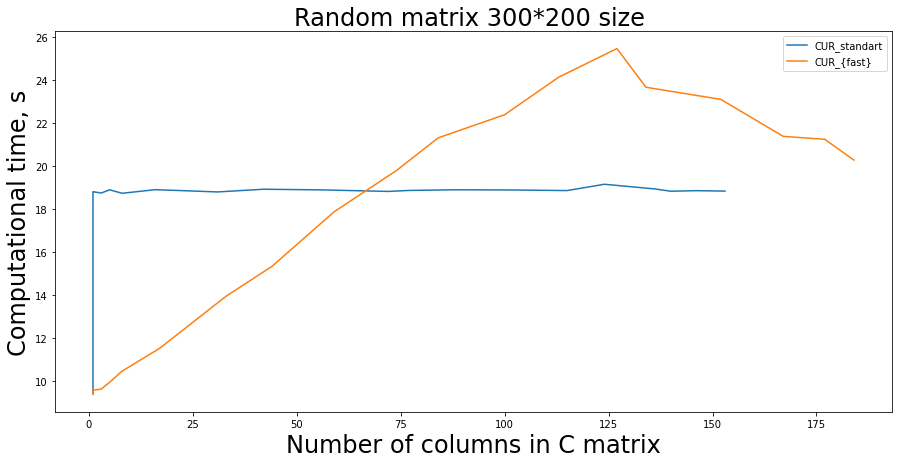

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(nonz_rows_old,time_old, label = 'CUR_standart')
plt.plot(nonz_rows, time1, label ='CUR_{fast}')
plt.xlabel('Number of columns in C matrix', fontsize=24)
plt.ylabel('Computational time, s', fontsize=24)
plt.legend()
plt.title("Random matrix {}*{} size ".format(n, p), fontsize=24)
# plt.plot(time2)